In [31]:
# plot distribution of weights of pretrained model and fine-tuned model
import numpy as np
import transformers
import seaborn as sns
import matplotlib.pyplot as plt

base_model = transformers.AutoModel.from_pretrained("facebook/opt-6.7b")
finetuned_model = transformers.AutoModel.from_pretrained(
    "KoboldAI/OPT-6.7B-Nerybus-Mix"
)

Loading checkpoint shards: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


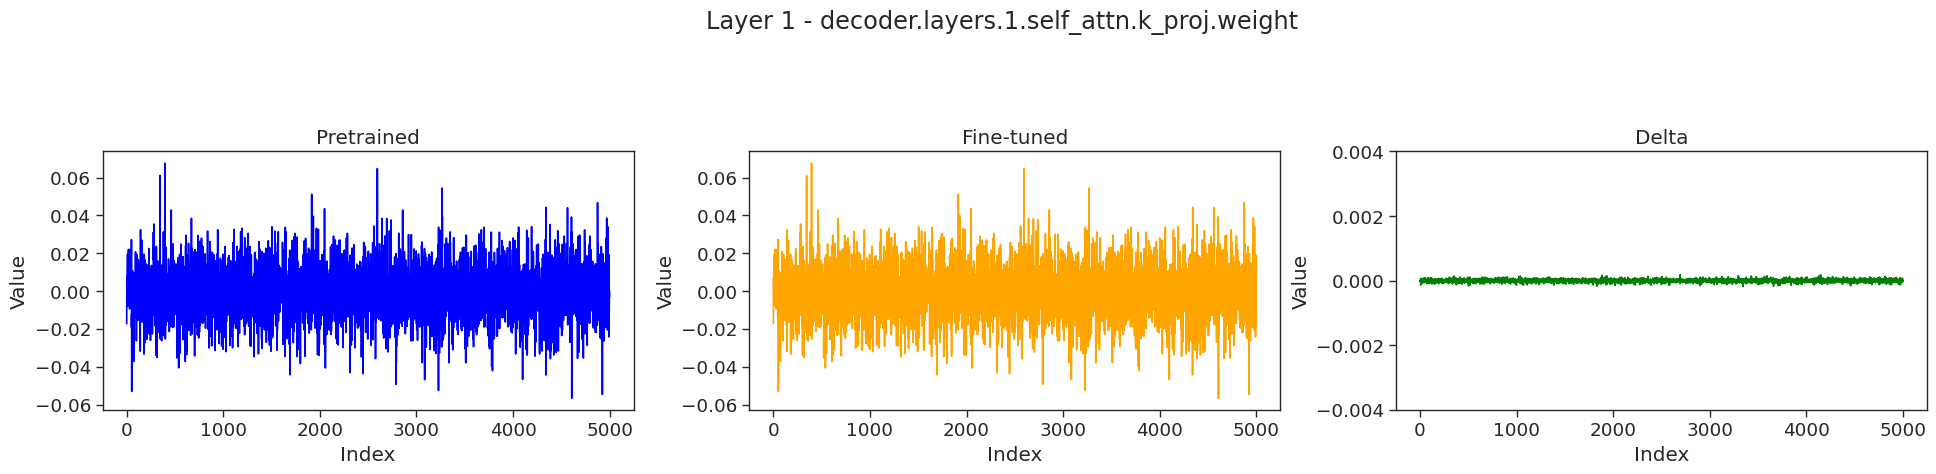

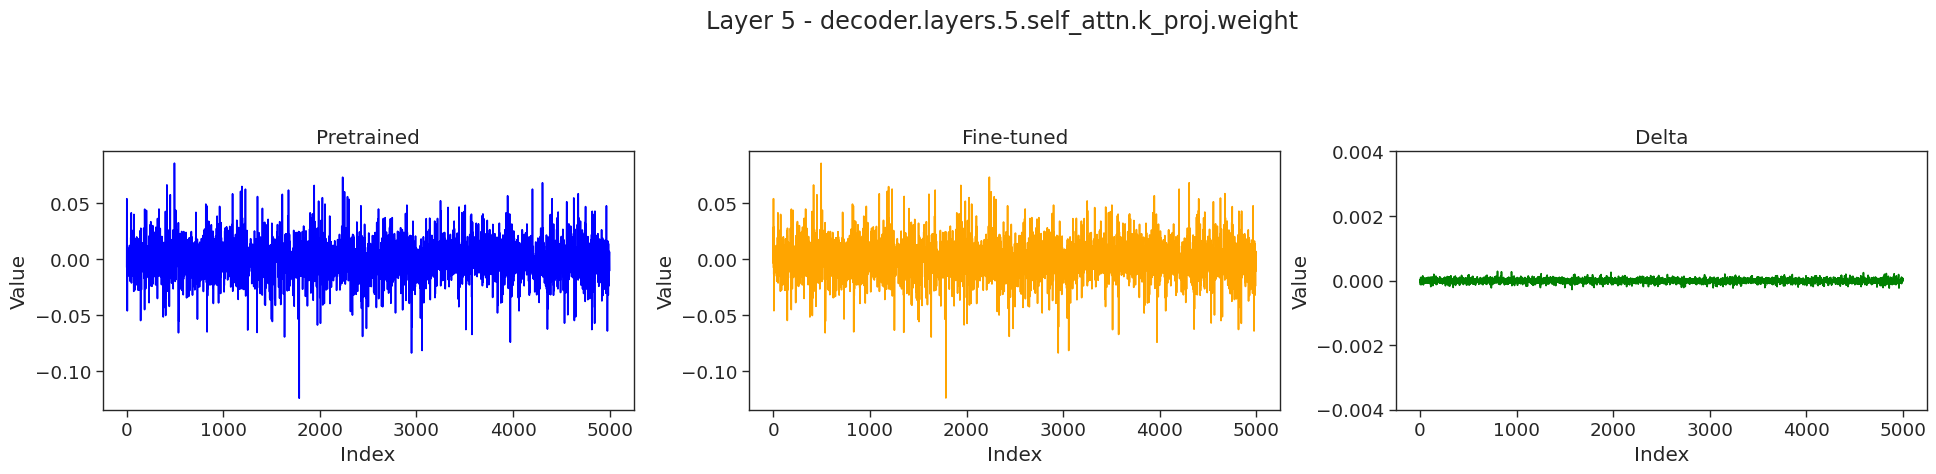

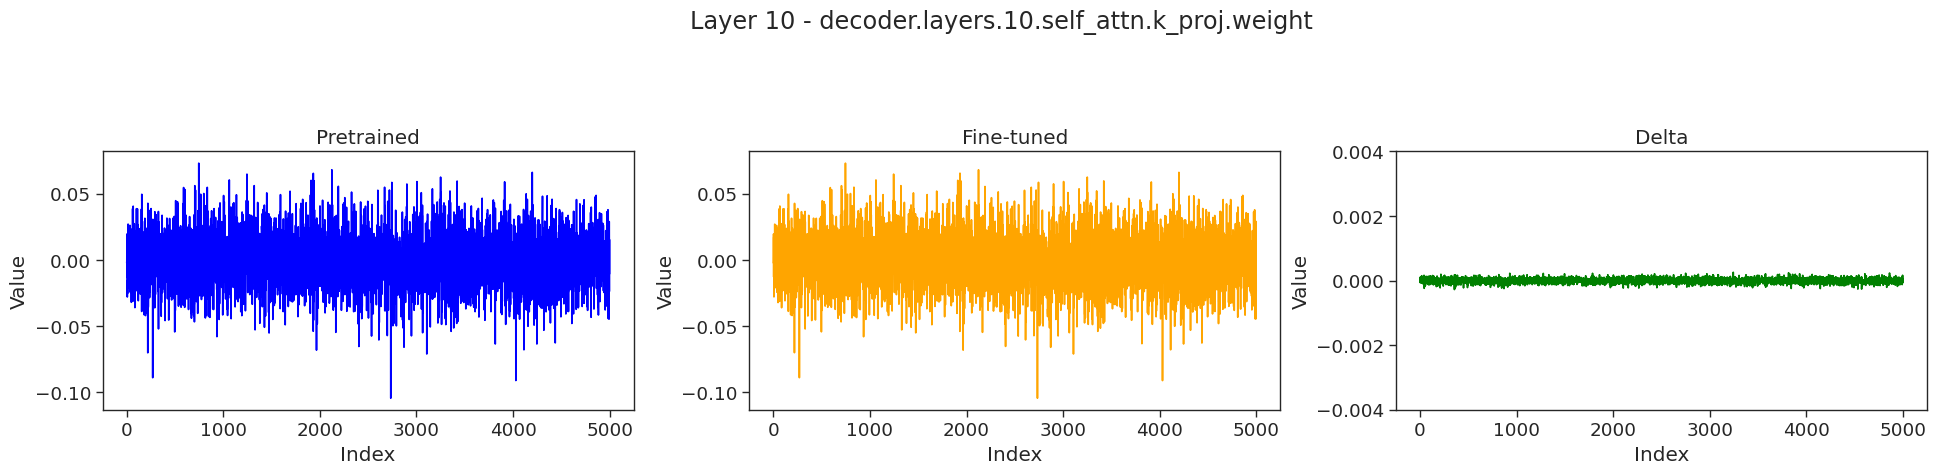

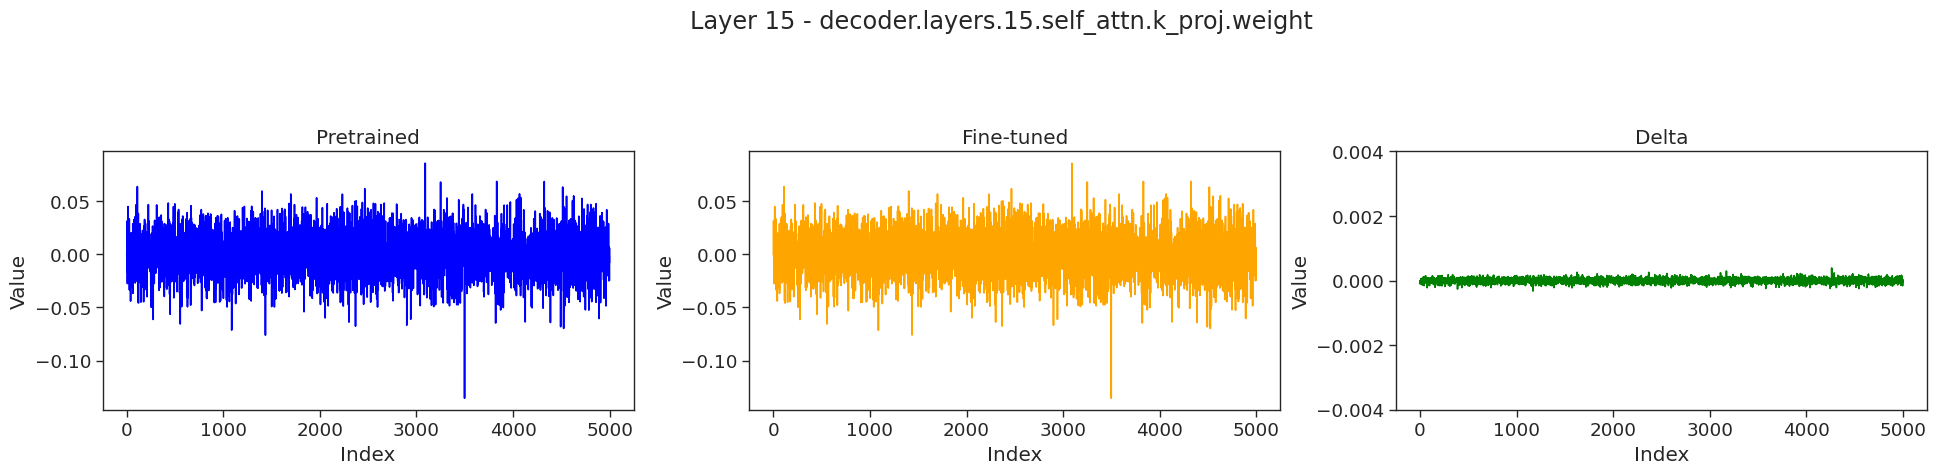

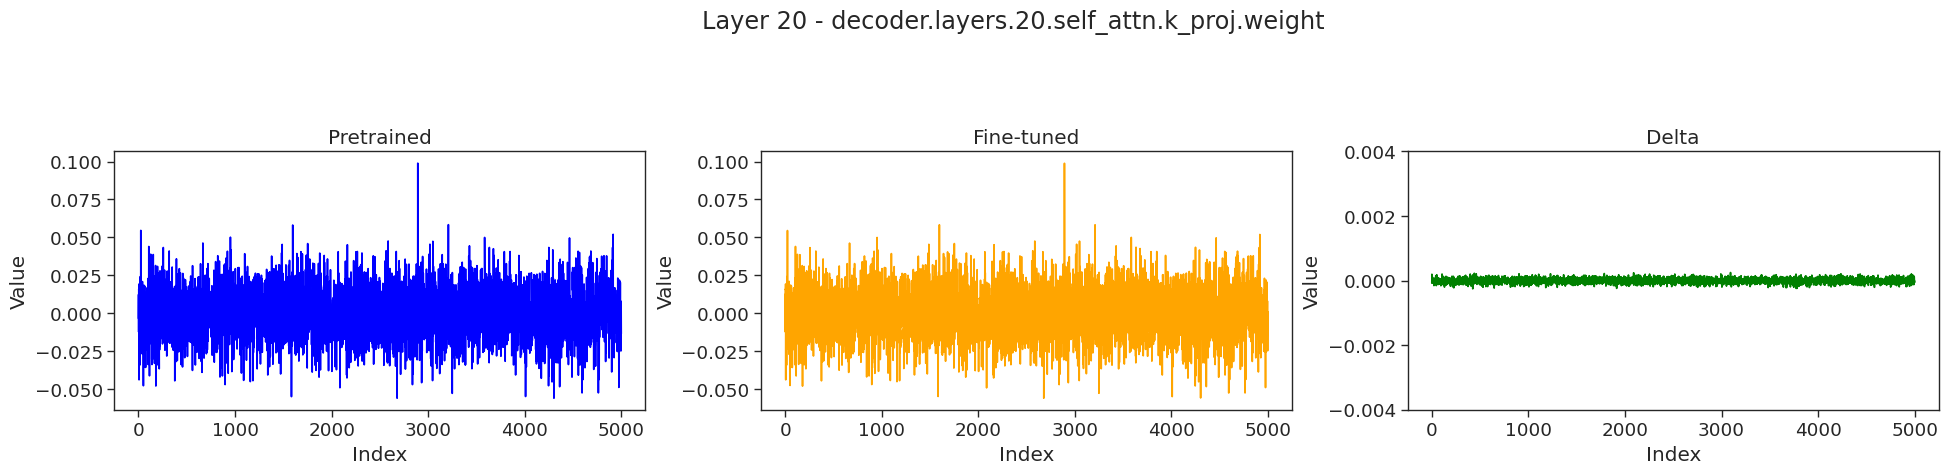

In [46]:
layers = [1, 5, 10, 15, 20]

for layer in layers:
    # print(finetuned_model.state_dict())
    # focus_name = f"layers.{layer}.self_attn.o_proj.weight"
    focus_name = f"decoder.layers.{layer}.self_attn.k_proj.weight"
    # plot distribution of weights of pretrained model and fine-tuned model
    plot_finetuned_weight = None
    plot_pretrained_weight = None
    plot_delta_weight = None

    plot_finetuned_weight = (
        finetuned_model.state_dict()[focus_name].flatten().cpu().numpy()
    )
    plot_pretrained_weight = base_model.state_dict()[focus_name].flatten().cpu().numpy()
    plot_delta_weight = plot_finetuned_weight - plot_pretrained_weight
    # report mean and std of weights
    # sample 1000 weights from the same indices
    sample_size = 5000
    sampled_indices = np.random.choice(
        len(plot_finetuned_weight), size=sample_size, replace=False
    )
    plot_finetuned_weight = plot_finetuned_weight[sampled_indices]
    plot_pretrained_weight = plot_pretrained_weight[sampled_indices]
    plot_delta_weight = plot_delta_weight[sampled_indices]
    sns.set_theme(style="whitegrid")
    sns.set(rc={"figure.figsize": (11.7, 8.27)})
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    sns.set_context("paper", font_scale=1.5)

    # make subplot
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Layer {layer} - {focus_name}")
    fig.tight_layout(pad=3.0)
    # plot distribution of weights of pretrained model
    sns.lineplot(ax=axs[0], data=plot_pretrained_weight, color="blue")
    axs[0].set_title("Pretrained")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Value")
    # set x limit to be the same as pretrained model

    # plot distribution of weights of fine-tuned model
    sns.lineplot(ax=axs[1], data=plot_finetuned_weight, color="orange")
    axs[1].set_title("Fine-tuned")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Value")
    axs[1].set_ylim(axs[0].get_ylim())
    # plot distribution of weights of fine-tuned model
    sns.lineplot(ax=axs[2], data=plot_delta_weight, color="green")
    axs[2].set_title("Delta")
    axs[2].set_xlabel("Index")
    axs[2].set_ylabel("Value")
    axs[2].set_ylim(-0.004, 0.004)
plt.show()